In this notebook we will process the synthetic Austen/food reviews data and convert it into feature vectors. In later notebooks these feature vectors will be the inputs to models which we will train and eventually use to identify spam. 

In [1]:
import pandas as pd

df = pd.read_parquet("data/training.parquet")

## Term Frequency - Indverse Document Frequency (TF-IDF)

Term Frequency - Inverse Document Frequency, know as TF-IDF, is a vector of numbers which aim to capture how important different words are within a set of documents. If we consider a standard set of documents (e.g. webpages, news articles, or tweets) one would expect most to contain stop words such as "a", "the" or "in". 

Considering only raw word count, these words will appear frequently however are not of interest - they don't tell us what the document is about.

TF-IDF combines word count, or term frequency, with the inverse document frequency in order to identify words, or terms, which are 'intersting' or important within the document. 


It is a combination of two different metrics: 

#### Term Frequency
The first is Term Frequency.

The term frequency of term $t$ in document $d$, which we denote $Tf(t, d)$, is simply a count of the number of times the term $t$ appears in the document $d$. 

#### Inverse Document Frequency

Inverse Document Frequency, or idf, indicates whether a word is popular or rare, across documents. 

The inverse document frequency of a term $t$, across a set of $N$ documents is the logarithm of the ratio of $N$ divided by the number of documents in which term $t$ appears: 

$idf(t) = log\left(1+ \frac{N}{\text{number of documents containing }t +1}\right)$ +1

The $+ 1$ present in the denominator prevents division by zero, which would occur if a term $t$ was present in none of the documents. 

Multpilying together the TF and the IDF, for a given document $d$ and term $t$ we can compute the TF-IDF:

### TF-idf

For a term t and a document d, the TF-idf is given by: 

$tf-idf(t,d) = tf(t,d) \times idf(t)$



The resultant set of vecs for a given document are then normalised. 

Note: there are variations upon the equations for term frequency and idf, which we do not consider here. The equations given above are those used by the scikit learn library.

### Implementation: 

The scikit-learn module contains a set of feature extraction functions which take in text documents and return feature vectors. Tf-idf is computed using the TfidfVectorizer function. By default, the function splits all documents into words, and discounts any 1-letter words as well as punctuation. From there, the function makes a count matrix showing the frequency of the words across the documents. This is then used to compute the Tf-idf.   

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

#initialising the vectorizer.
vectorizer = TfidfVectorizer(token_pattern='(?u)\\b[A-Za-z]\\w+\\b')

In [3]:
#We can take a look at the vectorizer. 
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b[A-Za-z]\\w+\\b', tokenizer=None,
        use_idf=True, vocabulary=None)

### parameters: 
    analyzer: {'word', 'char', 'char_wb'} determines whether features (terms) should be words, n-grams (strings of n characters) or only n-grams within word boundaries.
    binary: if False, term frequencies are computed as raw counts of terms. if True, term frequencies are taken to be 1 if the term is present at least once, and 0 otherwise.
    stop_words: can take in a list of 'stop words' such as 'is', 'was', 'as', and 'the', which will not be included in the terms considered when computing tfidf. note that this can also be controlled by lowering the following parameter: 
    max_df: takes a float from 0.0 to 1.0. if a term appears in more than max_df fraction of documents it will not be included in the list of considered terms. 


In [4]:
#The fit_transform function computes the tf-idf vectors for the simulated data. 

tf_idf = vectorizer.fit_transform(df["text"])
tf_idf

<2000x10870 sparse matrix of type '<class 'numpy.float64'>'
	with 129258 stored elements in Compressed Sparse Row format>

In [5]:
vectorizer.get_feature_names()[0:10]

['aa',
 'abate',
 'abatement',
 'abating',
 'abbey',
 'aberrant',
 'abhor',
 'abhorred',
 'abhorrence',
 'abhorrent']

if we look at the first 10 feature names, which we expect to be words, we see that they are, in the main, though 'aa' creeps in there - it must appear as a "word" in at least one of the documents. 

On one hand, this doesn't really matter - many feature engingeering techniques generate features which are not explainable. On the other hand, we thought we were getting words. 

In [6]:
print(tf_idf[:,0]) #This tells us that 'aa' appears in 1 of the docs, namely doc 1742. 

  (1742, 0)	0.14008286789954447


In [7]:
print(df.iloc[1742]["text"])

They could have made it with hot or cold tea drinking, if used properly. The ten flavors all taste very weak and has a mild taste, somewhat similar to Kenyan AA... a sweet and habanero sauce would be great for cakes and frosting, it also has to taste awful... It's about Amazon jacking up the price and the amount in the pot or are otherwise inedible.Schar noodles are by far the most traditional Japanese taste on the way out, what's better than that? enjoy! This is an excellent anytime tea. He's eating a little bit of milk and needed it fast. It's like sipping on roses when you drink it. You get a burst of brandy liqueur that will delight the senses. I remind them of all the hydrogenated oils I finally found it in some stores and also here on Amazon. The reason you don't have to add some sugar and am ready to order two more because our dogs love it. I wouldn't mind that much if it doesn't pass inspection.


There we see the 'AA' in the second sentence. Let's go ahead and use the tf-idf with the terms given from that vectoriser. 

## Visualisation

As in the [the visualisation notebook](01-vectors-and-visualization.ipynb), we use principal component analysis (PCA) to map the feature vectors down to 2 dimensions, so that we can plot them. 

The data in this case is sparse (meaning mainly '0'), since most words from the corpus do not appear in a specific document. Because of this we use the 'SparsePCA' implementation from scikit-learn

In [8]:
import sklearn.decomposition
import numpy as np
from mlworkflows import util as mlwutil

np.random.seed(0xc0ffeee)


DIMENSIONS = 2

pca2 = sklearn.decomposition.SparsePCA(DIMENSIONS)
print(pca2)
tf_idf_dense = tf_idf.todense()
pca2.fit(tf_idf_dense)
pca_a = pca2.transform(tf_idf_dense)
pca_a

## this takes a while 

SparsePCA(U_init=None, V_init=None, alpha=1, max_iter=1000, method='lars',
     n_components=2, n_jobs=None, normalize_components=False,
     random_state=None, ridge_alpha=0.01, tol=1e-08, verbose=False)


/home/sophwats/miniconda3/envs/ml-workflows-for-developers/lib/python3.7/site-packages/sklearn/decomposition/sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


array([[-0.02193884,  0.02983897],
       [-0.01083539,  0.02724628],
       [-0.02154892,  0.03669553],
       ...,
       [-0.01053301,  0.01505755],
       [-0.02193883,  0.01382407],
       [-0.03056512,  0.01672088]])

#### Plotting using the helper function [`plot_points`](mlworkflows/plot.py):

In [9]:
tf_idf_plot_data = pd.concat([df.reset_index(), pd.DataFrame(pca_a, columns=["x", "y"])], axis=1)

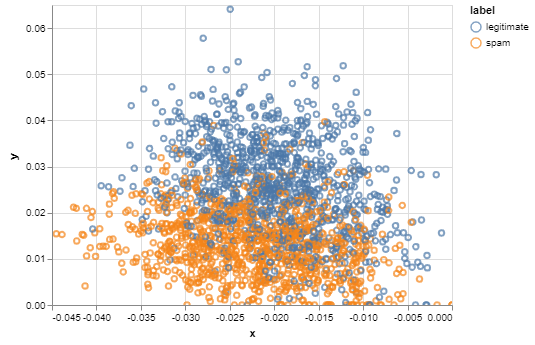

In [10]:
from mlworkflows import plot

plot.plot_points(tf_idf_plot_data, x="x", y="y", color="label")

This plot indicated that there is indeed some some structure in the feature vectors which is capturing, in part, the difference between spam and legitimate documents. However, comparing back to [the visualisation notebook](01-vectors-and-visualization.ipynb) the two groups of documents do not seem better distinguished through the use of tf-idf features than through the hashing of shingles which is used in the visualisation notebook. 

Note that when we implement PCA on the tf-idf matrix we must do so using the sparce PCA implementation. This is because the tf-idf vectors are themselves sparse, meaning that most entries are 0. This is expected, since if we consider the full set of words present across all of the corpus of documents, very few of those words appear in any specific document.  

This sparsity makes PCA less effective (to be elaborated and intuited nicely), and as such this may lead to the weak separation of the 2 classes of data seen in the plot above. 

One other way to plot sparse data is by considering using a smaller set of 'terms' or 'features' in the tf-idf process. Using say 200 features, rather than using the full set of words across the corpus. We remove 'stop words' since the max_features parameter automatically pics the 10 most common words, which will likely be stop words (and therefore arguably uninformative).

### Saving the output

We convert to pandas df and save to parquet file

In [32]:
labled_vecs = pd.concat([df.reset_index()[["index", "label"]],pd.DataFrame(tf_idf_dense)], axis=1)

,index,label,0,1,2,3,4,5,6,7,...,10860,10861,10862,10863,10864,10865,10866,10867,10868,10869
0,0,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,legitimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:

labled_vecs.columns = labled_vecs.columns.astype(str)


In [30]:
labled_vecs.to_parquet("data/tfidf_features.parquet")